In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# plt.ion()  # interactive mode


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "data/hymenoptera_data"
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


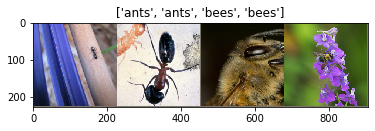

In [4]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100.0%


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6109 Acc: 0.6475
val Loss: 0.1826 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5734 Acc: 0.7992
val Loss: 0.2489 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4006 Acc: 0.8115
val Loss: 0.2412 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4820 Acc: 0.7828
val Loss: 0.3236 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.5028 Acc: 0.8074
val Loss: 0.2473 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.4130 Acc: 0.7992
val Loss: 0.4114 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.3664 Acc: 0.8648
val Loss: 0.2551 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3342 Acc: 0.8730
val Loss: 0.2293 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3827 Acc: 0.8484
val Loss: 0.2134 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3516 Acc: 0.8402
val Loss: 0.2292 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3246 Acc: 0.8607
val Loss: 0.2593 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.2629 Acc: 0.9139
val Loss: 0.2301 Acc: 0.9085

Ep

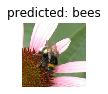

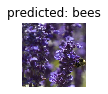

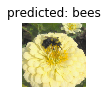

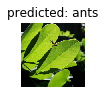

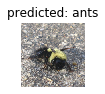

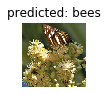

In [11]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor

In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6438 Acc: 0.6639
val Loss: 0.2997 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.5097 Acc: 0.7582
val Loss: 0.2821 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.6449 Acc: 0.6844
val Loss: 0.2154 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5348 Acc: 0.7869
val Loss: 0.2309 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4124 Acc: 0.8238
val Loss: 0.2379 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4649 Acc: 0.7828
val Loss: 0.2276 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.5676 Acc: 0.8033
val Loss: 0.2084 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3300 Acc: 0.8566
val Loss: 0.2203 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3371 Acc: 0.8443
val Loss: 0.2093 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4174 Acc: 0.8197
val Loss: 0.1983 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2807 Acc: 0.8648
val Loss: 0.2066 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3520 Acc: 0.8525
val Loss: 0.2003 Acc: 0.9412

Ep

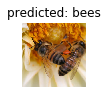

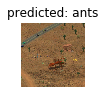

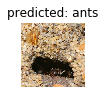

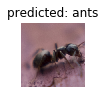

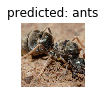

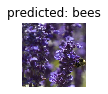

In [20]:
visualize_model(model_conv)
